<a href="https://colab.research.google.com/github/Bornord/DeepLearning/blob/main/Projet_LeVrai2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PROJET CLASSIFICATION

Fonction de chargement des données.
Nous avons des images RGB-A donc des images à 4 dimensions. Ces images sont mélangées.

In [56]:
IMAGE_SIZE = 256
CLASSES = ['akina','antoine','enguerran','skander','willem']

import glob
import PIL
from PIL import Image
import numpy as np
import os

def load_data(path, classes, image_size=64):

  # Liste les fichiers présents dans le dossier path
  tmp = 0
  for name in classes : 
      folder = path + name + '-image-files/'
      file_path =[folder+f for f in os.listdir(folder)]
      tmp = tmp + len(file_path)


  x = np.zeros((tmp, image_size, image_size, 4))
  y = np.zeros((tmp, len(classes)))
  for name in classes : 
      folder = path + name + '-image-files/'

      file_path =[folder+f for f in os.listdir(folder)]
      # Initialise les structures de données
      nb_file = len(file_path)
      for i in range(nb_file):
      # Lecture de l'image
          img = Image.open(file_path[i])
          # Mise à l'échelle de l'image
          img = img.resize((image_size,image_size), Image.ANTIALIAS)
          # Remplissage de la variable x
          x[classes.index(name)*nb_file + i] = np.asarray(img)

          class_label = classes.index(name)
      
          y[classes.index(name)*nb_file + i] = [0]*len(classes)
          y[classes.index(name)*nb_file + i][class_label] = 1

  return x, y

X_TRAIN, Y_TRAIN = load_data('../AudioCut/ImagesResultats/', CLASSES, image_size=IMAGE_SIZE)

# Normalisation des entrées via une division par 255 des valeurs de pixel.
X_TRAIN = X_TRAIN/255
import random
x_train_indexes = [i for i in range(len(X_TRAIN))]
random.shuffle(x_train_indexes)

X_VAL,Y_VAL = [X_TRAIN[i] for i in range((int) (len(X_TRAIN)/10))],[Y_TRAIN[i] for i in range((int) (len(Y_TRAIN)/10))]


Création du 1er réseau : Première partie convoluée et deuxième partie en réseau classique. On utilise les fonctions sigmoid et relu pour la classification. Enfin, on utilise un softmax en sortie pour déterminer qui parle dans l'enregistrement. On entraîne ce modèle avec 10 epochs. En augmantant le nombre d'epochs, on observe un sur apprentissage.

In [3]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import optimizers
model = Sequential()

model.add(Input(X_TRAIN[0].shape))
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', strides = 1, input_shape = (64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), input_shape = (64, 64, 3), padding = 'same'))

model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu', strides = 1, input_shape = (64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), input_shape = (64, 64, 3), padding = 'same'))
model.add(Conv2D(96, (3, 3), padding = 'same', activation = 'relu', strides = 1, input_shape = (64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), input_shape = (64, 64, 3), padding = 'same'))
model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu', strides = 1, input_shape = (64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), input_shape = (64, 64, 3), padding = 'same'))

model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense  
model.add(Dense(512, activation = 'relu', input_dim = 2)) 
model.add(Dense(256, activation = 'relu', input_dim = 2)) 
model.add(Dense(128, activation = 'sigmoid', input_dim = 2)) 
model.add(Dense(64, activation = 'sigmoid', input_dim = 2)) 
model.add(Dense(len(CLASSES),activation="sigmoid"))   # Couche de sortie
model.add(Softmax()) 

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

history = model.fit(np.array(X_TRAIN), np.array(Y_TRAIN), 
                    validation_data=(np.array(X_VAL), np.array(Y_VAL)),
                    epochs=10,
                    )


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       1

Test : évaluation des performances avec le modèle précédemment construit

In [4]:
X_TEST,Y_TEST = [X_TRAIN[i] for i in range((int) (len(X_TRAIN)/10))],[Y_TRAIN[i] for i in range((int) (len(Y_TRAIN)/10))]

model.evaluate(np.array(X_TEST),  np.array(Y_TEST), verbose=2)

2/2 - 0s - loss: 0.3911 - accuracy: 1.0000


[0.3910813629627228, 1.0]

Affichage de l'historique d'entraînement

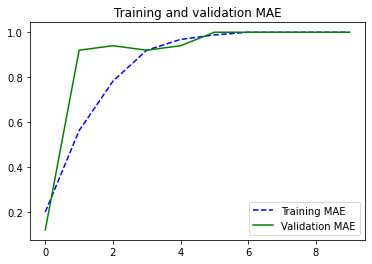

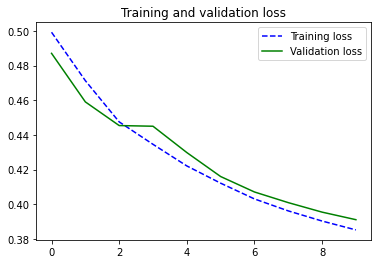

In [5]:
import matplotlib.pyplot as plt 

def plot_training_analysis(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training MAE')
  plt.plot(epochs, val_acc, 'g', label='Validation MAE')
  plt.title('Training and validation MAE')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

plot_training_analysis(history)


Test : fonction pour tester en direct avec un enregistrement de 5 secondes de la voix. décommenter la dernière ligne pour lancer le test.

In [7]:
from audioParsing import recordAudioToSpectogram
def recordAndAnalyse(model,audio_path,image_path):
    image = recordAudioToSpectogram(audio_path,image_path)
    image = image.resize((IMAGE_SIZE,IMAGE_SIZE), Image.ANTIALIAS)
    x = np.asarray(image)
    X = np.array([x])
    Y = model.predict(X)
    print(Y)
    plt.pie( [(int) (y*100) for y in Y[0]],labels=CLASSES)

#recordAndAnalyse(model,"./tmp.wav","./tmp.png")

    

Chargement des données de test en RGB-A. (lectures de 4 fables avec 3 versions pour chaque)

In [8]:
def load_data(path, classes,subpath, image_size=64):
  tmp = 0
  for name in classes : 
      folder = path + name + subpath
      file_path =[folder+f for f in os.listdir(folder)]
      tmp = tmp + len(file_path)


  x = np.zeros((tmp, image_size, image_size, 4))
  y = np.zeros((tmp, len(classes)+1))
  for name in classes : 
      folder = path + name + subpath

      file_path =[folder+f for f in os.listdir(folder)]
      nb_file = len(file_path)
      for i in range(nb_file):
          img = Image.open(file_path[i])
          img = img.resize((image_size,image_size), Image.ANTIALIAS)
          x[classes.index(name)*nb_file + i] = np.asarray(img)
          class_label = classes.index(name)
      
          y[classes.index(name)*nb_file + i] = [0]*(len(classes)+1)
          y[classes.index(name)*nb_file + i][class_label] = 1

  return x, y

X_TEST_CIGALE_DEFORMATION, Y_TEST_CIGALE_DEFORMATION = load_data('../AudioCut/ImagesResultats/', ['akina','antoine','enguerran','skander'],'-cigale-deformation-image-files/', image_size=IMAGE_SIZE)
X_TEST_CIGALE_NORMAL, Y_TEST_CIGALE_NORMAL = load_data('../AudioCut/ImagesResultats/', ['akina','antoine','enguerran','skander'],'-cigale-normal-image-files/', image_size=IMAGE_SIZE)
X_TEST_CIGALE_SON, Y_TEST_CIGALE_SON = load_data('../AudioCut/ImagesResultats/', ['akina','antoine','enguerran','skander'],'-cigale-son-image-files/', image_size=IMAGE_SIZE)

X_TEST_HERON_DEFORMATION, Y_TEST_HERON_DEFORMATION = load_data('../AudioCut/ImagesResultats/', ['akina','antoine','enguerran','skander'],'-heron-deformation-image-files/', image_size=IMAGE_SIZE)
X_TEST_HERON_NORMAL, Y_TEST_HERON_NORMAL = load_data('../AudioCut/ImagesResultats/', ['akina','antoine','enguerran','skander'],'-heron-normal-image-files/', image_size=IMAGE_SIZE)
X_TEST_HERON_SON, Y_TEST_HERON_SON = load_data('../AudioCut/ImagesResultats/', ['akina','antoine','enguerran','skander'],'-heron-son-image-files/', image_size=IMAGE_SIZE)

X_TEST_LABOUREUR_DEFORMATION, Y_TEST_LABOUREUR_DEFORMATION = load_data('../AudioCut/ImagesResultats/', ['akina','antoine','enguerran','skander'],'-laboureur-deformation-image-files/', image_size=IMAGE_SIZE)
X_TEST_LABOUREUR_NORMAL, Y_TEST_LABOUREUR_NORMAL = load_data('../AudioCut/ImagesResultats/', ['akina','antoine','enguerran','skander'],'-laboureur-normal-image-files/', image_size=IMAGE_SIZE)
X_TEST_LABOUREUR_SON, Y_TEST_LABOUREUR_SON = load_data('../AudioCut/ImagesResultats/', ['akina','antoine','enguerran','skander'],'-laboureur-son-image-files/', image_size=IMAGE_SIZE)

X_TEST_RENARD_DEFORMATION, Y_TEST_RENARD_DEFORMATION = load_data('../AudioCut/ImagesResultats/', ['akina','antoine','enguerran','skander'],'-renard-deformation-image-files/', image_size=IMAGE_SIZE)
X_TEST_RENARD_NORMAL, Y_TEST_RENARD_NORMAL = load_data('../AudioCut/ImagesResultats/', ['akina','antoine','enguerran','skander'],'-renard-normal-image-files/', image_size=IMAGE_SIZE)
X_TEST_RENARD_SON, Y_TEST_RENARD_SON = load_data('../AudioCut/ImagesResultats/', ['akina','antoine','enguerran','skander'],'-renard-son-image-files/', image_size=IMAGE_SIZE)


Test : évaluation des performances pour chaque catégore : normal, avec bruit, et déformation de la voix.

In [9]:
print("cigale deformation")
model.evaluate(np.array(X_TEST_CIGALE_DEFORMATION),  np.array(Y_TEST_CIGALE_DEFORMATION), verbose=2)
print("cigale normal")
model.evaluate(np.array(X_TEST_CIGALE_NORMAL),  np.array(Y_TEST_CIGALE_NORMAL), verbose=2)
print("cigale bruit")
model.evaluate(np.array(X_TEST_CIGALE_SON),  np.array(Y_TEST_CIGALE_SON), verbose=2)

print("heron deformation")
model.evaluate(np.array(X_TEST_HERON_DEFORMATION),  np.array(Y_TEST_HERON_DEFORMATION), verbose=2)
print("heron normal")
model.evaluate(np.array(X_TEST_HERON_NORMAL),  np.array(Y_TEST_HERON_NORMAL), verbose=2)
print("heron bruit")
model.evaluate(np.array(X_TEST_HERON_SON),  np.array(Y_TEST_HERON_SON), verbose=2)

print("laboureur deformation")
model.evaluate(np.array(X_TEST_LABOUREUR_DEFORMATION),  np.array(Y_TEST_LABOUREUR_DEFORMATION), verbose=2)
print("laboureur normal")
model.evaluate(np.array(X_TEST_LABOUREUR_NORMAL),  np.array(Y_TEST_LABOUREUR_NORMAL), verbose=2)
print("laboureur bruit")
model.evaluate(np.array(X_TEST_LABOUREUR_SON),  np.array(Y_TEST_LABOUREUR_SON), verbose=2)

print("renard deformation")
model.evaluate(np.array(X_TEST_RENARD_DEFORMATION),  np.array(Y_TEST_RENARD_DEFORMATION), verbose=2)
print("renard normal")
model.evaluate(np.array(X_TEST_RENARD_NORMAL),  np.array(Y_TEST_RENARD_NORMAL), verbose=2)
print("renard bruit")
model.evaluate(np.array(X_TEST_RENARD_SON),  np.array(Y_TEST_RENARD_SON), verbose=2)


cigale deformation
2/2 - 0s - loss: 0.4627 - accuracy: 0.5000
cigale normal
2/2 - 0s - loss: 0.4609 - accuracy: 0.5000
cigale bruit
2/2 - 0s - loss: 0.4584 - accuracy: 0.5000
heron deformation
2/2 - 0s - loss: 0.4972 - accuracy: 0.2500
heron normal
2/2 - 0s - loss: 0.4619 - accuracy: 0.5000
heron bruit
2/2 - 0s - loss: 0.4789 - accuracy: 0.3250
laboureur deformation
2/2 - 0s - loss: 0.4635 - accuracy: 0.5000
laboureur normal
2/2 - 0s - loss: 0.4601 - accuracy: 0.5000
laboureur bruit
2/2 - 0s - loss: 0.4678 - accuracy: 0.3750
renard deformation
2/2 - 0s - loss: 0.4621 - accuracy: 0.5000
renard normal
2/2 - 0s - loss: 0.4597 - accuracy: 0.5000
renard bruit
2/2 - 0s - loss: 0.4594 - accuracy: 0.5000


[0.4594383239746094, 0.5]

Augmentation des données : Entraînement du modèle avec les données des enregistrements déformés et bruités.

In [10]:
X_TRAIN_AUGMENTED = X_TEST_CIGALE_NORMAL + X_TEST_HERON_NORMAL + X_TEST_LABOUREUR_NORMAL + X_TEST_RENARD_NORMAL
Y_TRAIN_AUGMENTED = Y_TEST_CIGALE_NORMAL + Y_TEST_HERON_NORMAL + Y_TEST_LABOUREUR_NORMAL + Y_TEST_RENARD_NORMAL

X_VAL_AUGMENTED,Y_VAL_AUGMENTED = [X_TRAIN_AUGMENTED[i] for i in range((int) (len(X_TRAIN_AUGMENTED)/10))],[Y_TRAIN_AUGMENTED[i] for i in range((int) (len(Y_TRAIN_AUGMENTED)/10))]

history = model.fit(np.array(X_TRAIN_AUGMENTED), np.array(Y_TRAIN_AUGMENTED), 
                    validation_data=(np.array(X_VAL_AUGMENTED), np.array(Y_VAL_AUGMENTED)),
                    epochs=10,
                    )


Epoch 1/10
2/2 [==============================] - 1s 366ms/step - loss: 1.1596 - accuracy: 0.5000 - val_loss: 1.0345 - val_accuracy: 0.7500
Epoch 2/10
2/2 [==============================] - 1s 329ms/step - loss: 1.1206 - accuracy: 0.4000 - val_loss: 1.2799 - val_accuracy: 0.2500
Epoch 3/10
2/2 [==============================] - 1s 314ms/step - loss: 1.1633 - accuracy: 0.3750 - val_loss: 1.2516 - val_accuracy: 0.5000
Epoch 4/10
2/2 [==============================] - 1s 329ms/step - loss: 1.2071 - accuracy: 0.4000 - val_loss: 1.4354 - val_accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 1s 323ms/step - loss: 1.2113 - accuracy: 0.2500 - val_loss: 1.4618 - val_accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 1s 334ms/step - loss: 1.2289 - accuracy: 0.2500 - val_loss: 1.4196 - val_accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 1s 330ms/step - loss: 1.2117 - accuracy: 0.2500 - val_loss: 1.3572 - val_accuracy: 0.0000e+00
Epoc

Test : évaluation des performances après augmentation des données.

In [11]:
print("cigale deformation")
model.evaluate(np.array(X_TEST_CIGALE_DEFORMATION),  np.array(Y_TEST_CIGALE_DEFORMATION), verbose=2)
print("cigale normal")
model.evaluate(np.array(X_TEST_CIGALE_NORMAL),  np.array(Y_TEST_CIGALE_NORMAL), verbose=2)
print("cigale bruit")
model.evaluate(np.array(X_TEST_CIGALE_SON),  np.array(Y_TEST_CIGALE_SON), verbose=2)

print("heron deformation")
model.evaluate(np.array(X_TEST_HERON_DEFORMATION),  np.array(Y_TEST_HERON_DEFORMATION), verbose=2)
print("heron normal")
model.evaluate(np.array(X_TEST_HERON_NORMAL),  np.array(Y_TEST_HERON_NORMAL), verbose=2)
print("heron bruit")
model.evaluate(np.array(X_TEST_HERON_SON),  np.array(Y_TEST_HERON_SON), verbose=2)

print("laboureur deformation")
model.evaluate(np.array(X_TEST_LABOUREUR_DEFORMATION),  np.array(Y_TEST_LABOUREUR_DEFORMATION), verbose=2)
print("laboureur normal")
model.evaluate(np.array(X_TEST_LABOUREUR_NORMAL),  np.array(Y_TEST_LABOUREUR_NORMAL), verbose=2)
print("laboureur bruit")
model.evaluate(np.array(X_TEST_LABOUREUR_SON),  np.array(Y_TEST_LABOUREUR_SON), verbose=2)

print("renard deformation")
model.evaluate(np.array(X_TEST_RENARD_DEFORMATION),  np.array(Y_TEST_RENARD_DEFORMATION), verbose=2)
print("renard normal")
model.evaluate(np.array(X_TEST_RENARD_NORMAL),  np.array(Y_TEST_RENARD_NORMAL), verbose=2)
print("renard bruit")
model.evaluate(np.array(X_TEST_RENARD_SON),  np.array(Y_TEST_RENARD_SON), verbose=2)

cigale deformation
2/2 - 0s - loss: 0.4680 - accuracy: 0.2750
cigale normal
2/2 - 0s - loss: 0.4653 - accuracy: 0.2500
cigale bruit
2/2 - 0s - loss: 0.4654 - accuracy: 0.4500
heron deformation
2/2 - 0s - loss: 0.4639 - accuracy: 0.3250
heron normal
2/2 - 0s - loss: 0.4699 - accuracy: 0.1750
heron bruit
2/2 - 0s - loss: 0.4698 - accuracy: 0.3750
laboureur deformation
2/2 - 0s - loss: 0.4650 - accuracy: 0.2750
laboureur normal
2/2 - 0s - loss: 0.4654 - accuracy: 0.2250
laboureur bruit
2/2 - 0s - loss: 0.4650 - accuracy: 0.3500
renard deformation
2/2 - 0s - loss: 0.4661 - accuracy: 0.3500
renard normal
2/2 - 0s - loss: 0.4625 - accuracy: 0.4000
renard bruit
2/2 - 0s - loss: 0.4641 - accuracy: 0.3750


[0.46412864327430725, 0.375]

# Transfert d'apprentissage



Transfert d'apprentissage avec ResNet afin de récupérer les données résiduelles de l'image. Afin d'utiliser nos images à 4 dimensions, on augmente la taille des images acceptée par le réseau ResNet .

In [32]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

def multify_weights(kernel, out_channels):
  mean_1d = np.mean(kernel, axis=-2).reshape(kernel[:,:,-1:,:].shape)
  tiled = np.tile(mean_1d, (out_channels, 1))
  return(tiled)


def weightify(model_orig, custom_model, layer_modify):
  layer_to_modify = [layer_modify]

  conf = custom_model.get_config()
  layer_names = [conf['layers'][x]['name'] for x in range(len(conf['layers']))]

  for layer in model_orig.layers:
    if layer.name in layer_names:
      if layer.get_weights() != []:
        target_layer = custom_model.get_layer(layer.name)

        if layer.name in layer_to_modify:    
          kernels = layer.get_weights()[0]
          biases  = layer.get_weights()[1]

          kernels_extra_channel = np.concatenate((kernels,
                                                  multify_weights(kernels, 4 - 3)),
                                                  axis=-2)
                                                  
          target_layer.set_weights([kernels_extra_channel, biases])
          target_layer.trainable = False

        else:
          target_layer.set_weights(layer.get_weights())
          target_layer.trainable = False


resnet50 = ResNet50V2(weights='imagenet', include_top=False)

config = resnet50.get_config()
config["layers"][0]["config"]["batch_input_shape"] = (None, IMAGE_SIZE, IMAGE_SIZE, 4)
config["layers"][2]["config"]["strides"] = (1, 1)


resnet_custom = Model.from_config(config)
modify_name = config["layers"][2]["config"]["name"]


weightify(resnet50, resnet_custom, modify_name)




On ajoute à un réseau pré existant des couches afin d'adapter le modèle à notre problème.

In [33]:
model = Sequential()
model.add(resnet_custom)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(CLASSES),activation="sigmoid"))   # Couche de sortie
model.add(Softmax()) 


In [34]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

history = model.fit(np.array(X_TRAIN), np.array(Y_TRAIN), 
                    validation_data=(np.array(X_VAL), np.array(Y_VAL)),
                    epochs=10,
                    )

Epoch 1/10
16/16 [==============================] - 77s 5s/step - loss: 0.4517 - accuracy: 0.3620 - val_loss: 0.3800 - val_accuracy: 0.9200
Epoch 2/10
16/16 [==============================] - 74s 5s/step - loss: 0.4475 - accuracy: 0.3900 - val_loss: 0.3800 - val_accuracy: 1.0000
Epoch 3/10
16/16 [==============================] - 74s 5s/step - loss: 0.4466 - accuracy: 0.3960 - val_loss: 0.3804 - val_accuracy: 0.9600
Epoch 4/10
16/16 [==============================] - 73s 5s/step - loss: 0.4469 - accuracy: 0.4000 - val_loss: 0.3800 - val_accuracy: 1.0000
Epoch 5/10
16/16 [==============================] - 75s 5s/step - loss: 0.4465 - accuracy: 0.3980 - val_loss: 0.3800 - val_accuracy: 0.9800
Epoch 6/10
16/16 [==============================] - 75s 5s/step - loss: 0.4469 - accuracy: 0.3980 - val_loss: 0.3800 - val_accuracy: 1.0000
Epoch 7/10
16/16 [==============================] - 75s 5s/step - loss: 0.4469 - accuracy: 0.3980 - val_loss: 0.3800 - val_accuracy: 1.0000
Epoch 8/10
16/16 [==

Affichage de l'historique

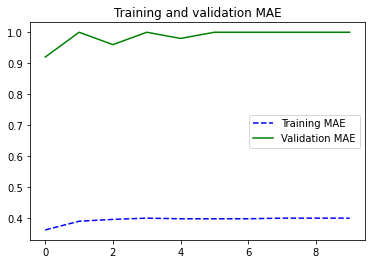

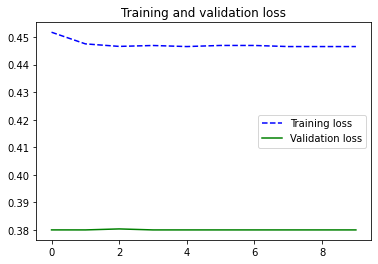

In [35]:
plot_training_analysis(history)

Test : évaluation des performances

In [36]:
X_TEST,Y_TEST = [X_TRAIN[i] for i in range((int) (len(X_TRAIN)/10))],[Y_TRAIN[i] for i in range((int) (len(Y_TRAIN)/10))]

model.evaluate(np.array(X_TEST),  np.array(Y_TEST), verbose=2)

2/2 - 6s - loss: 0.3800 - accuracy: 1.0000


[0.3799959123134613, 1.0]

Chargement des données en RGB afin d'avoir des images en 3 dimensions. (On perd le paramètre de transparence des images) Ainsi on pourra tester le transfert learning avec d'autres réseaux.

In [50]:
def load_data_3(path, classes, image_size=64):

  tmp = 0
  for name in classes : 
      folder = path + name + '-image-files/'
      file_path =[folder+f for f in os.listdir(folder)]
      tmp = tmp + len(file_path)


  x = np.zeros((tmp, image_size, image_size, 3))
  y = np.zeros((tmp, len(classes)))
  for name in classes : 
      folder = path + name + '-image-files/'

      file_path =[folder+f for f in os.listdir(folder)]
      nb_file = len(file_path)
      for i in range(nb_file):
          img = Image.open(file_path[i])
          # Mise à l'échelle de l'image
          img = img.resize((image_size,image_size), Image.ANTIALIAS)
          img = np.asarray(img)[:, :, :3]
          # Remplissage de la variable x
          x[classes.index(name)*nb_file + i] = np.asarray(img)

          class_label = classes.index(name)
      
          y[classes.index(name)*nb_file + i] = [0]*len(classes)
          y[classes.index(name)*nb_file + i][class_label] = 1

  return x, y

X_TRAIN, Y_TRAIN = load_data_3('../AudioCut/ImagesResultats/', CLASSES, image_size=IMAGE_SIZE)

# Normalisation des entrées via une division par 255 des valeurs de pixel.
X_TRAIN = X_TRAIN/255
import random
x_train_indexes = [i for i in range(len(X_TRAIN))]
random.shuffle(x_train_indexes)

X_TRAIN, Y_TRAIN = [X_TRAIN[i] for i in x_train_indexes],[Y_TRAIN[i] for i in x_train_indexes]
X_VAL,Y_VAL = [X_TRAIN[i] for i in range((int) (len(X_TRAIN)/10))],[Y_TRAIN[i] for i in range((int) (len(Y_TRAIN)/10))]


In [51]:
model = Sequential()
# A COMPLETER"

model.add(Input(X_TRAIN[0].shape))
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', strides = 1, input_shape = (64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), input_shape = (64, 64, 3), padding = 'same'))

model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu', strides = 1, input_shape = (64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), input_shape = (64, 64, 3), padding = 'same'))
model.add(Conv2D(96, (3, 3), padding = 'same', activation = 'relu', strides = 1, input_shape = (64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), input_shape = (64, 64, 3), padding = 'same'))
model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu', strides = 1, input_shape = (64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), input_shape = (64, 64, 3), padding = 'same'))

model.add(Flatten())  
model.add(Dense(512, activation = 'relu', input_dim = 2)) 
model.add(Dense(256, activation = 'relu', input_dim = 2)) 
model.add(Dense(128, activation = 'sigmoid', input_dim = 2)) 
model.add(Dense(64, activation = 'sigmoid', input_dim = 2)) 
model.add(Dense(len(CLASSES),activation="sigmoid"))   # Couche de sortie
model.add(Softmax()) 

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

history = model.fit(np.array(X_TRAIN), np.array(Y_TRAIN), 
                    validation_data=(np.array(X_VAL), np.array(Y_VAL)),
                    epochs=10,
                    )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 96)        55392     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 128)      

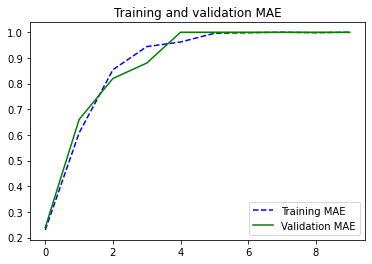

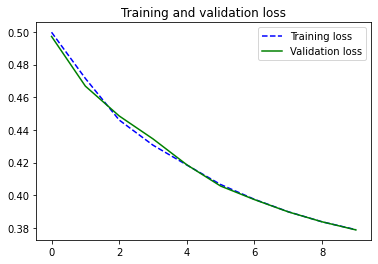

2/2 - 0s - loss: 0.3788 - accuracy: 1.0000


[0.3787514567375183, 1.0]

In [52]:
plot_training_analysis(history)
X_TEST,Y_TEST = [X_TRAIN[i] for i in range((int) (len(X_TRAIN)/10))],[Y_TRAIN[i] for i in range((int) (len(Y_TRAIN)/10))]

model.evaluate(np.array(X_TEST),  np.array(Y_TEST), verbose=2)

Transfert d'apprentissage avec le réseau VGG16

In [53]:
vgg16 = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(CLASSES),activation="sigmoid"))   # Couche de sortie
model.add(Softmax()) 

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

history = model.fit(np.array(X_TRAIN), np.array(Y_TRAIN), 
                    validation_data=(np.array(X_VAL), np.array(Y_VAL)),
                    epochs=10,
                    )



Epoch 1/10
16/16 [==============================] - 151s 9s/step - loss: 0.5216 - accuracy: 0.2140 - val_loss: 0.5118 - val_accuracy: 0.2600
Epoch 2/10
16/16 [==============================] - 152s 10s/step - loss: 0.5263 - accuracy: 0.2000 - val_loss: 0.5118 - val_accuracy: 0.2600
Epoch 3/10
16/16 [==============================] - 155s 10s/step - loss: 0.5263 - accuracy: 0.2000 - val_loss: 0.5118 - val_accuracy: 0.2600
Epoch 4/10
16/16 [==============================] - 152s 10s/step - loss: 0.5263 - accuracy: 0.2000 - val_loss: 0.5118 - val_accuracy: 0.2600
Epoch 5/10
16/16 [==============================] - 151s 9s/step - loss: 0.5263 - accuracy: 0.2000 - val_loss: 0.5118 - val_accuracy: 0.2600
Epoch 6/10
16/16 [==============================] - 156s 10s/step - loss: 0.5263 - accuracy: 0.2000 - val_loss: 0.5118 - val_accuracy: 0.2600
Epoch 7/10
16/16 [==============================] - 156s 10s/step - loss: 0.5263 - accuracy: 0.2000 - val_loss: 0.5118 - val_accuracy: 0.2600
Epoch 8/

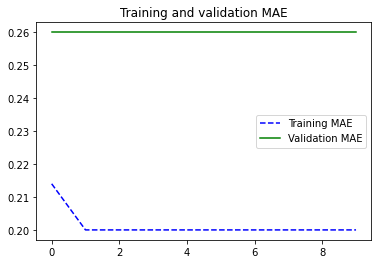

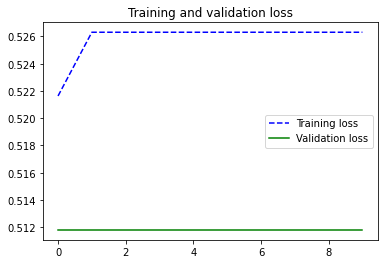

2/2 - 4s - loss: 0.5118 - accuracy: 0.2600


[0.5118093490600586, 0.25999999046325684]

In [54]:
plot_training_analysis(history)
X_TEST,Y_TEST = [X_TRAIN[i] for i in range((int) (len(X_TRAIN)/10))],[Y_TRAIN[i] for i in range((int) (len(Y_TRAIN)/10))]

model.evaluate(np.array(X_TEST),  np.array(Y_TEST), verbose=2)

Transfert d'apprentissage avec le réseau MobileNet

Epoch 1/10
16/16 [==============================] - 39s 2s/step - loss: 0.3817 - accuracy: 0.5000 - val_loss: 0.4597 - val_accuracy: 0.5600
Epoch 2/10
16/16 [==============================] - 36s 2s/step - loss: 0.3412 - accuracy: 0.8380 - val_loss: 0.4824 - val_accuracy: 0.6800
Epoch 3/10
16/16 [==============================] - 36s 2s/step - loss: 0.3246 - accuracy: 0.9520 - val_loss: 0.4782 - val_accuracy: 0.5200
Epoch 4/10
16/16 [==============================] - 37s 2s/step - loss: 0.3146 - accuracy: 0.9900 - val_loss: 0.4677 - val_accuracy: 0.3800
Epoch 5/10
16/16 [==============================] - 37s 2s/step - loss: 0.3180 - accuracy: 0.9540 - val_loss: 0.5052 - val_accuracy: 0.2600
Epoch 6/10
16/16 [==============================] - 37s 2s/step - loss: 0.3118 - accuracy: 0.9940 - val_loss: 0.5093 - val_accuracy: 0.2600
Epoch 7/10
16/16 [==============================] - 37s 2s/step - loss: 0.3117 - accuracy: 0.9960 - val_loss: 0.5061 - val_accuracy: 0.2600
Epoch 8/10
16/16 [==

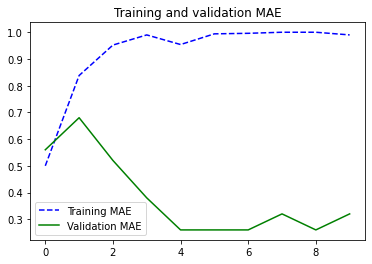

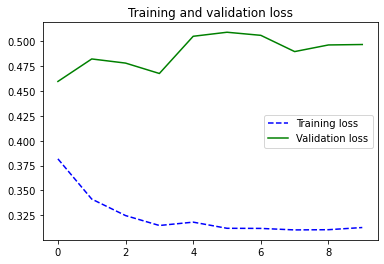

2/2 - 1s - loss: 0.4969 - accuracy: 0.3200


[0.49689850211143494, 0.3199999928474426]

In [55]:
mobilenet = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(CLASSES),activation="sigmoid"))   # Couche de sortie
model.add(Softmax()) 

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

history = model.fit(np.array(X_TRAIN), np.array(Y_TRAIN), 
                    validation_data=(np.array(X_VAL), np.array(Y_VAL)),
                    epochs=10,
                    )
plot_training_analysis(history)
X_TEST,Y_TEST = [X_TRAIN[i] for i in range((int) (len(X_TRAIN)/10))],[Y_TRAIN[i] for i in range((int) (len(Y_TRAIN)/10))]

model.evaluate(np.array(X_TEST),  np.array(Y_TEST), verbose=2)